## Set up simple flow

Move current directory to project root

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

if 'project_root' not in dir():
    project_root = Path.cwd().parent
    
os.chdir(project_root)

Toy dataset

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from model_zoo.datasets.generated import Sphere
from model_zoo.datasets.utils import OmitLabels

dataset = Sphere('', 'test', manifold_dim=1, ambient_dim=2, mu=np.array([-3, -3]))
device = 'cpu' if not torch.cuda.is_available() else 'cuda:0'
dataset = dataset.to(device)
data_vec = dataset.x
dataloader = DataLoader(OmitLabels(dataset), batch_size=50)

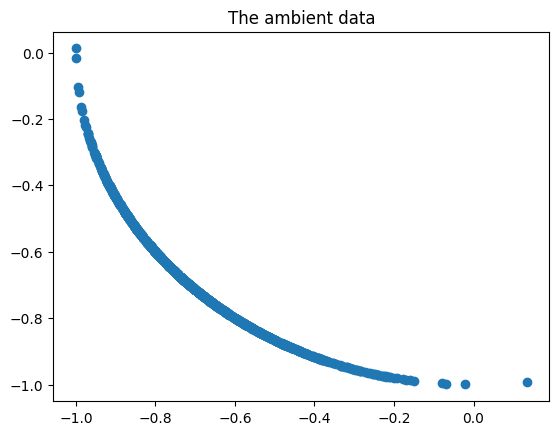

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dataset.x.cpu()[:, 0], dataset.x.cpu()[:, 1])
plt.title("The ambient data")
plt.show()

Construct a flow consisting of one simple linear transformation

In [4]:
from torch import optim
from model_zoo.density_estimator.flow import NormalizingFlow

flow = NormalizingFlow(
    dim=2,
    transform=[{
        'class_path': 'nflows.transforms.lu.LULinear',
        'init_args': {
            'features': 2
        }
    }],
).to(device)

optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda step: 1
)

flow.optimizer = optimizer
flow.lr_scheduler = scheduler

In [5]:
print(flow.device)

cuda:0


Train the flow

In [6]:
from tqdm import tqdm
for epoch in tqdm(range(1000), desc="Training the flow model"):
    for batch in dataloader:
        flow.train_batch(batch)
    

Training the flow model: 100%|██████████| 1000/1000 [00:41<00:00, 24.01it/s]


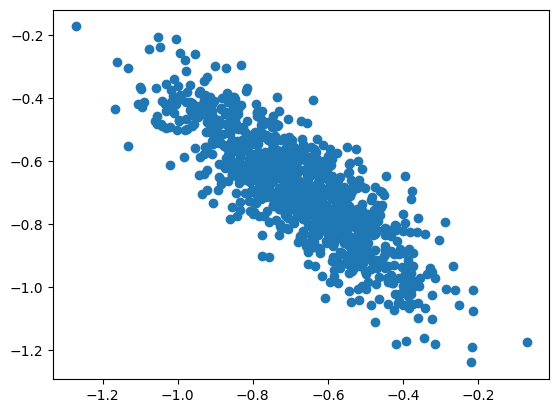

In [7]:

gen_sample = flow.sample(1000).cpu().detach()
plt.scatter(gen_sample[:, 0], gen_sample[:, 1])

Evaluate 

In [77]:
from ood.methods.linear_approximations.latent_statistics import EllipsoidCDFStatsCalculator
from ood.methods.linear_approximations.encoding_model import EncodingFlow


ellipsoid_calc = EllipsoidCDFStatsCalculator(
    flow, 
    encoding_model_class = EncodingFlow, 
    encoding_model_args = {
        'use_functorch': False, 
        'use_forward_mode': True, 
        'use_vmap': True
    }, 
    verbose=1
)
# create a dataloader out of the first 3 batches of dataloader
sampling_loader = torch.utils.data.DataLoader(
    dataloader.dataset[:10],
    batch_size=2,
)
jax, z_values = ellipsoid_calc.encoding_model.calculate_jacobian(
    loader=sampling_loader,
    stack_back=True,
)

In [78]:
for x_, z_, jac_ in zip(sampling_loader, z_values, jax):
    for x, z, jac in zip(x_, z_, jac_):
        print("x =", x)
        latent = ellipsoid_calc.encoding_model.encode(x.unsqueeze(0)).squeeze(0)
        print("latent =", latent)
        decoded = ellipsoid_calc.encoding_model.decode(latent.unsqueeze(0)).squeeze(0)
        print("decoded =", decoded)
        
        print(z)
        print("J =", jac)
        print("---")
        print("J.z", (jac @ z.reshape(-1, 1)).flatten(), "x", x)
        print("***")

x = tensor([-0.7684, -0.6399], device='cuda:0')
latent = tensor([-0.5362, -0.0952], device='cuda:0')
decoded = tensor([-0.7684, -0.6399], device='cuda:0')
tensor([-0.5362, -0.0952])
J = tensor([[ 0.1692, -0.0533],
        [-0.1089,  0.1361]])
---
J.z tensor([-0.0856,  0.0454]) x tensor([-0.7684, -0.6399], device='cuda:0')
***
x = tensor([-0.7372, -0.6757], device='cuda:0')
latent = tensor([-0.3998, -0.2488], device='cuda:0')
decoded = tensor([-0.7372, -0.6757], device='cuda:0')
tensor([-0.3998, -0.2488])
J = tensor([[ 0.1692, -0.0533],
        [-0.1089,  0.1361]])
---
J.z tensor([-0.0544,  0.0097]) x tensor([-0.7372, -0.6757], device='cuda:0')
***
x = tensor([-0.8418, -0.5398], device='cuda:0')
latent = tensor([-0.8063,  0.4244], device='cuda:0')
decoded = tensor([-0.8418, -0.5398], device='cuda:0')
tensor([-0.5362, -0.0952])
J = tensor([[ 0.1692, -0.0533],
        [-0.1089,  0.1361]])
---
J.z tensor([-0.0856,  0.0454]) x tensor([-0.8418, -0.5398], device='cuda:0')
***
x = tensor([-0.7

In [ ]:


ellipsoid_samples = ellipsoid_calc.sample(0.01, sampling_loader, 1000)

In [30]:
print(len(ellipsoid_samples))
print(ellipsoid_samples[0].shape)

10
torch.Size([1000, 2])


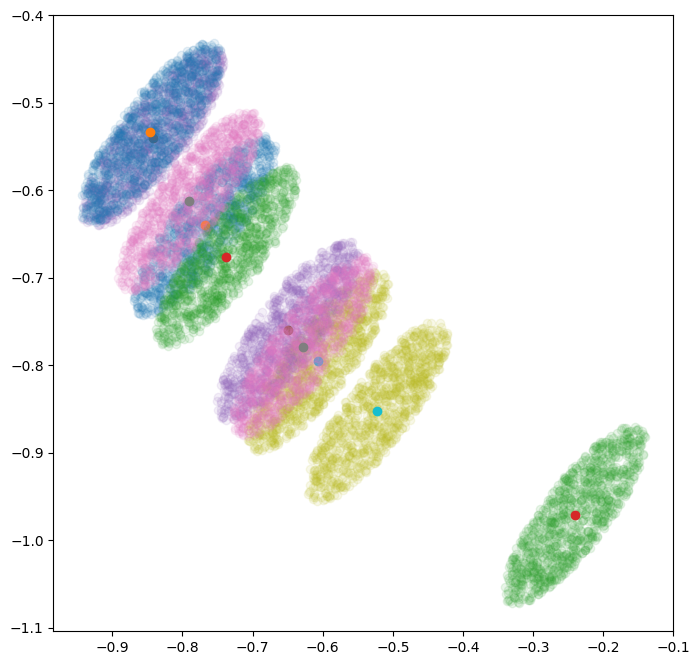

In [40]:
plt.figure(figsize=(8, 8))
for sample, dvec in zip(ellipsoid_samples, data_vec):
    plt.scatter(sample[:, 0].cpu(), sample[:, 1].cpu(), alpha=0.1)
    plt.scatter(dvec[:1].cpu(), dvec[1:].cpu()) 
plt.show()